In [15]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
import glob
import pandas as pd
import numpy as np

import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies')
import explore_qml_data as eqd

### Define smiles strings for selected molecules

In [16]:
# get smiles string for structure -> make canonical

# benzene derivates
benzene_derivates = ['Cc1ccccc1', 'Nc1ccccc1', 'Oc1ccccc1']

# cyclohexane derivatives
cyclohexane_derivates = ['CC1CCCCC1', 'OC1CCCCC1']

# conjugated vs saturated
#conj_sat = ['C=C/C=C/C', 'C=C/C=C/N', 'C=C/C=C/O'] # , 'CCCCC', 'CCCCN', 'CCCCO'

# change in number of electrons
changing_Ne = ['C', 'CC', 'CCC', 'CCCC', 'CCCCC', 'CCCCCC']

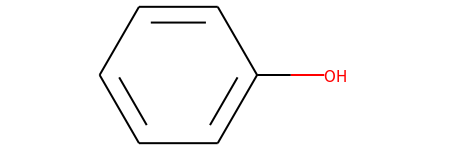

In [19]:
Chem.MolFromSmiles('Oc1ccccc1')

### Make database with all canonical smiles strings

In [ ]:
# get smiles strings for all molecules in qm9 -> make canonical
files = glob.glob('/home/misa/datasets/qm9/dsgdb9nsd_*')
files.sort()
data = pd.DataFrame(index=np.arange(len(files)), columns=['name', 'smiles canonical', 'path'])

In [ ]:
canonical_smiles = []
names = []
for i, f in enumerate(files):
    # get smiles
    if i in 13388*np.arange(0, 9):
        print(i)
    smiles = eqd.get_smiles(f)
    canonical_smiles.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles)))
#     if smiles != Chem.MolToSmiles(Chem.MolFromSmiles(smiles)):
#         print(f)
    #get name
    names.append(f.split('/')[-1].split('.')[0])

In [ ]:
data['name'] = names
data['smiles canonical'] = canonical_smiles
data['path'] = files

In [ ]:
molecule_paths = []

for mol in ['c1ccccc1']:
    canonical_smile = Chem.MolToSmiles(Chem.MolFromSmiles(mol))
    molecule_paths.append(data.loc[data['smiles canonical'] == canonical_smile, 'path'].item())

In [ ]:
molecule_paths

### Find path to smiles in database

In [ ]:
molecule_paths = []

for smile in ['CC(C)CCO', 'CCCC(C)C']:
    canonical_smile = Chem.MolToSmiles(Chem.MolFromSmiles(smile))
    molecule_paths.append(data.loc[data['smiles canonical'] == canonical_smile, 'path'].item())

In [ ]:
molecule_paths

In [ ]:
molecule_paths = []
# benzene
for mol in benzene_derivates:
    canonical_smile = Chem.MolToSmiles(Chem.MolFromSmiles(mol))
    molecule_paths.append(data.loc[data['smiles canonical'] == canonical_smile, 'path'].item())
    
for mol in cyclohexane_derivates:
    canonical_smile = Chem.MolToSmiles(Chem.MolFromSmiles(mol))
    molecule_paths.append(data.loc[data['smiles canonical'] == canonical_smile, 'path'].item())
    
# for mol in conj_sat:
#     canonical_smile = Chem.MolToSmiles(Chem.MolFromSmiles(mol)).capitalize()
#     molecule_paths.append(data.loc[data['smiles canonical'] == canonical_smile, 'path'].item())
    
for mol in changing_Ne:
    canonical_smile = Chem.MolToSmiles(Chem.MolFromSmiles(mol))
    molecule_paths.append(data.loc[data['smiles canonical'] == canonical_smile, 'path'].item())

In [ ]:
molecule_paths = ['/home/misa/datasets/qm9/dsgdb9nsd_000930.xyz',
 '/home/misa/datasets/qm9/dsgdb9nsd_000940.xyz',
 '/home/misa/datasets/qm9/dsgdb9nsd_000949.xyz',
 '/home/misa/datasets/qm9/dsgdb9nsd_002102.xyz',
 '/home/misa/datasets/qm9/dsgdb9nsd_002110.xyz',
 '/home/misa/datasets/qm9/dsgdb9nsd_000001.xyz',
 '/home/misa/datasets/qm9/dsgdb9nsd_000007.xyz',
 '/home/misa/datasets/qm9/dsgdb9nsd_000013.xyz',
 '/home/misa/datasets/qm9/dsgdb9nsd_000039.xyz',
 '/home/misa/datasets/qm9/dsgdb9nsd_000133.xyz',
 '/home/misa/datasets/qm9/dsgdb9nsd_000543.xyz']

In [ ]:
molecule_paths = ['/home/misa/datasets/qm9/dsgdb9nsd_000272.xyz']

In [ ]:
mols_selected = []
for m in molecule_paths:
    s = eqd.get_smiles(m)
    mols_selected.append(Chem.MolFromSmiles(s))

In [ ]:
Chem.Draw.MolsToGridImage(mols_selected,molsPerRow=10,subImgSize=(200,200), maxMols=1000)    

In [ ]:
smiles = []
with open('/home/misa/datasets/qm9/correct_smiles.txt') as f:
    for line in f:
        smiles.append(line.split()[0])

In [ ]:
c5 = []
for s in smiles:
    upper = s.upper()
    if "C=C" in s and not 'O' in upper and not 'N' in upper and not 'F' in upper:
        c5.append(s)

In [ ]:
db = []
for s in smiles:
    upper = s.upper()
    if "C=C" in s and not "1" in s:
        db.append(s)

In [ ]:
mols = [Chem.MolFromSmiles(s) for s in db]

In [ ]:
Chem.Draw.MolsToGridImage(mols,molsPerRow=10,subImgSize=(200,200), maxMols=1000)    

# Select molecules representative of QM9 with respect to local environments

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors

from rdkit.Chem.Draw import IPythonConsole
import glob
import pandas as pd
import numpy as np

import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies')
import explore_qml_data as eqd

from matplotlib import pyplot as plt

### Make database

In [ ]:
def get_nn(atom):
    """
    returns ist with items = (bond order, element), where items are nearest neighbours
    """
    nn = []
    for n, b in zip(atom.GetNeighbors(), atom.GetBonds()):
        el = n.GetSymbol()
        bo = b.GetBondTypeAsDouble()
        nn.append((bo, el))
    return(nn)
def get_local_rep(atom):
    """
    make local rep of atom
    """
    atomtype = atom.GetSymbol() # element type of atom
    nn = get_nn(atom)
    nn.sort() # sort by bond order
    
    bo1 = ''
    bo1p5 = ''
    bo2 = ''
    bo3 = ''
    for n in nn:
        if n[0] == 1.0:
            bo1 += n[1]
        elif n[0] == 1.5:
            bo1p5 += n[1]
        elif n[0] == 2:
            bo2 += n[1]
        elif n[0] == 3:
            bo3 += n[1]
        else:
            raise Exception('Something went wrong.')
    bo1 = ''.join(sorted(bo1))
    bo1p5 = ''.join(sorted(bo1p5))
    bo2 = ''.join(sorted(bo2))
    bo3 = ''.join(sorted(bo3))
    local_rep = f'{atomtype}|{bo1}|{bo1p5}|{bo2}|{bo3}'
    return(local_rep)

smiles = []
smiles_path = []
dissociated = []
error = []
with open('/home/misa/datasets/qm9/correct_smiles.txt') as f:
    for line in f:
        if '.' in line.split()[0]:
            dissociated.append(line)
        elif 'error' in line:
            error.append(line)
        else:
            smiles.append(line.split()[0])
            smiles_path.append(line.split()[1])
mols = []

for s in smiles:
    mols.append(Chem.MolFromSmiles(s))
    
reps = []
smiles_again = []
num_ve = []
for mol, s in zip(mols, smiles):
    for atom in mol.GetAtoms():
        reps.append(get_local_rep(atom))
        num_ve.append(Descriptors.NumValenceElectrons(mol))
        smiles_again.append(s)
        
database = pd.DataFrame(data = {'rep':reps, 'num ve': num_ve, 'smiles':smiles_again}, index=np.arange(len(reps)), columns=['rep', 'num ve', 'smiles'])
database.to_pickle('/home/misa/projects/Atomic-Energies/data/diversity_loc_env.pd')

### Make distributions

In [ ]:
database = pd.read_pickle('/home/misa/projects/Atomic-Energies/data/diversity_loc_env.pd')

reps = database['rep']
unique_reps = set(reps)
unique_ve = set(database['num ve'])

repname = []
num_ve = []
num_reps = []
max_it = len(unique_reps)*len(unique_ve)
counter = 0
pr_m = True
for ur in unique_reps:
    for uv in unique_ve:
        repname.append(ur)
        num_ve.append(uv)
        num_reps.append(len(database.loc[(database['rep'] == ur) & (database['num ve'] == uv), 'rep']))
        
        counter += 1
        if counter/max_it > 0.25 and counter/max_it < 0.5:
            if pr_m: 
                print('25% done')
                pr_m = False
        elif counter/max_it > 0.5 and counter/max_it < 0.75:
            if not pr_m:
                print('50% done')
                pr_m = True
        elif counter/max_it > 0.75 and counter/max_it < 1.0:
            if pr_m: 
                print('75% done')
                pr_m = False
        elif counter/max_it > 0.95:
            if not pr_m:
                print('Almost there')
                pr_m = True
#     for ve in unique_slice['num ve']:
#         num_reps.append(len(unique_slice.loc[unique_slice['num ve'] == ve, ['rep']]))

rep_distribution = pd.DataFrame(data={'rep':repname, 'num_ve': num_ve, 'num_reps':num_reps})
rep_distribution.to_pickle('/home/misa/projects/Atomic-Energies/data/local_env_distribution.pd')

In [ ]:
rep_distribution = pd.DataFrame(data={'rep':repname, 'num_ve': num_ve, 'num_reps':num_reps})
rep_distribution.to_pickle('/home/misa/projects/Atomic-Energies/data/local_env_distribution.pd')

### Analyse data

In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt

In [2]:
database = pd.read_pickle('/home/misa/projects/Atomic-Energies/data/diversity_loc_env.pd')
rep_distribution = pd.read_pickle('/home/misa/projects/Atomic-Energies/data/local_env_distribution.pd')

In [3]:
reps = database['rep']
unique_reps = set(reps)
unique_ve = list(set(database['num ve']))
unique_ve.sort()
num_reps_matrix = np.reshape(np.array(rep_distribution['num_reps']), (len(unique_reps), len(unique_ve)))


### slice with fixed number of valence electrons with most unique environments

In [9]:
# slice with most unique environments
ur_vs_uve = []
for ve in unique_ve:
    ur_vs_uve.append(len(rep_distribution.loc[(rep_distribution['num_ve']==ve) & (rep_distribution['num_reps'] > 0), 'rep']))
ur_vs_uve = np.array(ur_vs_uve)
print(f"Number of valence elctrons = {np.array(unique_ve)[np.where(np.amax(ur_vs_uve) == ur_vs_uve)][0]}")

Number of valence elctrons = 48


Text(0, 0.5, 'num unique local envs')

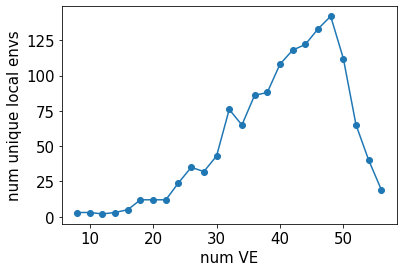

In [14]:
plt.rcParams['font.size'] = 15
plt.plot(unique_ve, ur_vs_uve, '-o')
plt.xlabel('num VE')
plt.ylabel('num unique local envs')

In [5]:
# How often should every environment occur in the subset selected for SCF calculations?
def get_ideal_num_reps(total_num_reps):
    ideal_num = 0
    if total_num_reps < 10: # for reps with occurence < 10 pick only 1 molecule each
        ideal_num = 1
    elif total_num_reps > 9 and total_num_reps < 1000: # for reps with occurence 10 <= occ < 1000
        ideal_num = int(np.round(total_num_reps*0.1))
    return(ideal_num)

def remove_smiles_duplicates(selected_smiles, smiles_tmp):
    new_smiles = set(smiles_tmp) - set(selected_smiles)
    return(list(new_smiles))

def select_smiles(database, distribution_48, lenv):
    """
    selects smiles depending on desired occurences of local environment lenv and number of times lenv was already selected
    """
    
    # how many smiles to select; number of occurences ideally - number of actual occurences (from selection of other smiles before)
    num_smiles = distribution_48.loc[distribution_48['rep'] == lenv, 'ideal_num_reps'].item() 
    - distribution_48.loc[distribution_48['rep'] == lenv, 'actual_num_reps'].item()

    # selection procedure
    if num_smiles > 0:
        selected_smiles = []
        smiles_lenv = list(database.loc[(database['rep']==lenv) & (database['num ve']==48), 'smiles'])
        if len(smiles_lenv) > num_smiles:
            selected_smiles = random.sample(smiles_lenv, int(num_smiles))
        else:
            selected_smiles = smiles_lenv
    return(selected_smiles)

def select_additional_smiles(database, lenv, num_smiles):
    """
    selects smiles depending on desired occurences of local environment lenv and number of times lenv was already selected
    """
    
    # selection procedure
    if num_smiles > 0:
        selected_smiles = []
        smiles_lenv = list(database.loc[(database['rep']==lenv) & (database['num ve']==48), 'smiles'])
        if len(smiles_lenv) > num_smiles:
            selected_smiles = random.sample(smiles_lenv, int(num_smiles))
        else:
            selected_smiles = smiles_lenv
    return(selected_smiles)

def update(database, distribution_48, selected_smiles):
    local_envs = [] # local environments in selected smiles
    for s in selected_smiles:
        local_envs.extend(list(database.loc[(database['smiles']==s) & (database['num ve']==48), 'rep']))

    for lenv in local_envs: # count how often each local env is now present in distribution_48
        distribution_48.loc[distribution_48['rep']==lenv, 'actual_num_reps'] = distribution_48.loc[distribution_48['rep']==lenv, 'actual_num_reps'].item() + 1

In [6]:
reps_48 = list(rep_distribution.loc[(rep_distribution['num_ve']==48) & (rep_distribution['num_reps'] > 0), 'rep']) # representations with 48 ve

# number of times these representations occur in molecules with 48 ve
num_rep_48 = np.array(rep_distribution.loc[(rep_distribution['num_ve']==48) & (rep_distribution['num_reps'] > 0), 'num_reps']) 

# sort representation by increasing order of occurence
table = []
for n, r in zip(num_rep_48, reps_48):
    table.append([n, r])
table.sort()
num_rep_48 = []
reps_48 = []
for n in table:
    num_rep_48.append(n[0])
    reps_48.append(n[1])

# make dataframe with reps and occurences sorted by increasing occurence
distribution_48 = pd.DataFrame(data={'rep': reps_48, 'tot_num_reps': num_rep_48})

# set ideal number of reps
# get ideal occurence for all environments that occure less than 1000 times
ideal_occ = np.zeros(len(num_rep_48))
ideal_occ[:] = np.nan

for i, tnr in enumerate(distribution_48.loc[distribution_48['tot_num_reps'] < 1000, 'tot_num_reps']):
    ideal_occ[i] = get_ideal_num_reps(tnr)

distribution_48['ideal_num_reps'] = ideal_occ
distribution_48['actual_num_reps']= np.zeros(len(num_rep_48))

In [7]:
# all envs for which I want to select smiles
selected_smiles = []
local_envs = distribution_48.loc[distribution_48['tot_num_reps'] < 1000, 'rep']
for lenv in local_envs:
    # find smiles that contain local env lenv
    smiles_tmp = select_smiles(database, distribution_48, lenv)
    # remove duplicates if smiles in smiles_tmp was selected in previous iteration
    smiles_tmp = remove_smiles_duplicates(selected_smiles, smiles_tmp)
    
    # update occurence of local envs
    update(database, distribution_48, smiles_tmp)
    selected_smiles.extend(smiles_tmp)

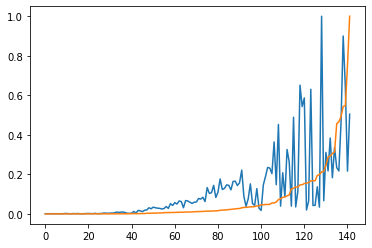

In [8]:
plt.plot(distribution_48['actual_num_reps']/max(distribution_48['actual_num_reps']))

plt.plot(distribution_48['tot_num_reps']/max(distribution_48['tot_num_reps']))

under_sampled = distribution_48.loc[distribution_48['actual_num_reps']/max(distribution_48['actual_num_reps']) - distribution_48['tot_num_reps']/max(distribution_48['tot_num_reps']) < 0]

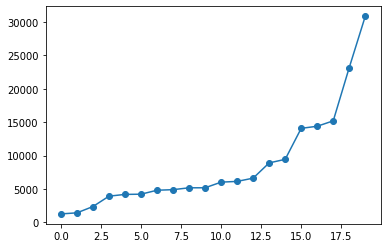

In [9]:
plt.plot(np.array(under_sampled['tot_num_reps']), '-o')

In [10]:
tot_num_additional_smiles = 3000 - len(selected_smiles)
num_additional_smiles = np.round(under_sampled['tot_num_reps']/under_sampled['tot_num_reps'].sum()*tot_num_additional_smiles)
add_lenvs = distribution_48.loc[distribution_48['actual_num_reps']/max(distribution_48['actual_num_reps']) - distribution_48['tot_num_reps']/max(distribution_48['tot_num_reps']) < 0, 'rep']



In [11]:
num_additional_smiles

99       9.0
100     10.0
109     17.0
114     29.0
116     31.0
117     31.0
121     35.0
122     36.0
124     38.0
125     38.0
126     44.0
127     45.0
129     48.0
131     65.0
133     69.0
135    103.0
136    105.0
137    111.0
140    169.0
141    225.0
Name: tot_num_reps, dtype: float64

In [16]:
# all envs for which I want to select smiles
additional_smiles = []
for lenv, nums in zip(add_lenvs, num_additional_smiles):
    # find smiles that contain local env lenv
    smiles_tmp = select_additional_smiles(database, lenv, nums)
    # remove duplicates if smiles in smiles_tmp was selected in previous iteration
    smiles_tmp = remove_smiles_duplicates(additional_smiles, smiles_tmp)
    smiles_tmp = remove_smiles_duplicates(selected_smiles, smiles_tmp)
    
    # update occurence of local envs
    update(database, distribution_48, smiles_tmp)
    additional_smiles.extend(smiles_tmp)

In [18]:
len(set(additional_smiles) - set(selected_smiles))

1213

In [20]:
len(additional_smiles)

1213

In [21]:
new_smiles = list(set(additional_smiles) - set(selected_smiles) )
selected_smiles.extend(new_smiles)

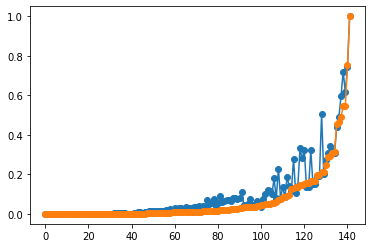

In [24]:
plt.plot(distribution_48['actual_num_reps']/max(distribution_48['actual_num_reps']), '-o')

plt.plot(distribution_48['tot_num_reps']/max(distribution_48['tot_num_reps']), '-o')

In [26]:
with open('/home/misa/projects/Atomic-Energies/data/ueg_reference/data_selection/smiles_ve_48.txt', 'w') as f:
    for i in selected_smiles:
        f.write(i+'\n')